# 01. Data Preparation

1. Merge separate files for each league and statistic type
2. Calculate percentage above/below team average for each player statistic
3. Aggregate original pre-transformation data per team for team-level statistics
4. Apply Principal Component Analysis (PCA) to reduce the dimensionality of player statistics separately for each statistic group
5. Apply PCA to reduce the dimensionality of team statistics
6. Create tags to combine FBRef statistics with Football Manager and FC24 ratings

In [2]:
# change wd to repo home
import os
if os.getcwd().split('\\')[-1] == 'notebooks':
    os.chdir('..')

In [3]:
from modules.fm_functions import *
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
tqdm.pandas()

## 01. Merge separate files for each league and statistic type

In [5]:
season = '2022'

# load FBRef data in separate dfs
fbref_dfs = {filename : pd.read_csv(f'data/FBRef_split/{filename}', index_col=0)
             for filename in os.listdir('data/FBRef_split')
             if filename.split('_')[-1][:4] == season}

In [6]:
# combine FBRef dfs by type first
table_types = ['defense', 'gca', 'keepersadv', 'keepers', 'misc', 'passingtypes',
               'passing', 'playingtime', 'possession', 'shooting', 'stats']

fbref_dfs_types = {}

for t in table_types:
    fbref_dfs_types[t] = {}
    for k in fbref_dfs.keys():
        if k.split('_')[1] == t:
            fbref_dfs_types[t][k.split('_')[0]] = fbref_dfs[k]
    try:
        fbref_dfs_types[t] = pd.concat(fbref_dfs_types[t], axis=0, ignore_index=True).set_index(['_Player', '_Squad', '_Born'])
    except:
        print(t)

In [7]:
# combine FBRef dfs into one
fbref_combined_df = pd.concat(fbref_dfs_types, axis=1).reset_index()
fbref_combined_df.columns = fbref_combined_df.columns.map(lambda x: '_'.join(map(str, x)))

In [8]:
# drop keepers
fbref_combined_df = fbref_combined_df[fbref_combined_df['stats__Pos']!='GK']
# drop unknown YOB
fbref_combined_df = fbref_combined_df.dropna(subset=['_Born_'])
fbref_combined_df['yob'] = fbref_combined_df['_Born_'].astype('int')
# drop players with less than 500 minutes
fbref_combined_df = fbref_combined_df[fbref_combined_df['playingtime_PlayingTime_Min'] >= 500]

## 02. Calculate percentage above/below team average for each player statistic

In [9]:
def percent_above_below(group):
    return (group - group.mean()) / group.mean()

In [10]:
fbref_meandiff_df = fbref_combined_df.copy()

for column_group in [defense_columns, touches_columns, passing_columns,
                     progres_columns, attack_columns, misc_columns]:
        fbref_meandiff_df[column_group] = fbref_meandiff_df.groupby('_Squad_')[column_group].transform(percent_above_below)

In [11]:
fbref_meandiff_df.head()

,_Player_,_Squad_,_Born_,defense__Rk,defense__Nation,defense__Pos,defense__Age,defense__90s,defense_Tackles_Tkl,defense_Tackles_TklW,...,stats_Per90Minutes_G+A,stats_Per90Minutes_G-PK,stats_Per90Minutes_G+A-PK,stats_Per90Minutes_xG,stats_Per90Minutes_xAG,stats_Per90Minutes_xG+xAG,stats_Per90Minutes_npxG,stats_Per90Minutes_npxG+xAG,stats_Matches,yob
1,Sargis Adamyan,Köln,1993,2.0,am ARM,FWMF,29.0,7.2,-0.573604,-0.646067,...,0.42,0.14,0.42,0.47,0.11,0.58,0.47,0.58,Matches,1993
2,Karim Adeyemi,Dortmund,2002,3.0,de GER,FWMF,20.0,15.4,-0.443223,-0.334395,...,0.71,0.39,0.71,0.33,0.24,0.57,0.28,0.52,Matches,2002
3,Amine Adli,Leverkusen,2000,4.0,ma MAR,FWMF,22.0,15.9,-0.331878,-0.348659,...,0.50,0.31,0.50,0.31,0.11,0.42,0.31,0.42,Matches,2000
5,Naouirou Ahamada,Stuttgart,2002,6.0,fr FRA,MF,20.0,15.5,-0.404814,-0.338346,...,0.26,0.13,0.26,0.05,0.08,0.13,0.05,0.13,Matches,2002
6,Ludovic Ajorque,Mainz 05,1994,7.0,fr FRA,FWMF,28.0,13.5,-0.788104,-0.716418,...,0.52,0.45,0.52,0.34,0.13,0.47,0.34,0.47,Matches,1994


In [12]:
fbref_meandiff_df[all_stats_columns].columns[fbref_meandiff_df[all_stats_columns].isnull().sum() > 0]

Index(['shooting_Standard_Dist'], dtype='object')

In [13]:
fbref_meandiff_df['shooting_Standard_Dist'].isnull().sum()

15

In [14]:
fbref_meandiff_df.dropna(subset=['shooting_Standard_Dist'], inplace=True)

In [15]:
fbref_meandiff_df = fbref_meandiff_df[['_Player_', '_Born_', '_Squad_'] + all_stats_columns]

In [16]:
fbref_meandiff_df.to_csv(f'data/{season}_FBRef_meandiff.csv')

## 03. Aggregate original pre-transformation data per team for team-level statistics.

In [17]:
team_stats_df = fbref_combined_df.groupby('_Squad_')[all_stats_columns].mean()

In [18]:
team_stats_df.columns[team_stats_df.isnull().sum() > 0]

Index([], dtype='object')

In [19]:
team_stats_df.to_csv(f'data/{season}_FBRef_teams.csv')

## 04. Apply PCA to reduce the dimensionality of player statistics separately for each statistic group:
- defense
- touches
- passing
- progression
- attack
- miscelaneous

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.8)

In [21]:
stat_types_dict.keys()

dict_keys(['defense', 'touches', 'passing', 'progres', 'attack', 'misc'])

In [22]:
fbref_pca_df = fbref_meandiff_df.copy()[['_Player_', '_Born_', '_Squad_']]
pca_types_dict = {}

for column_group in stat_types_dict.keys():
        current_columns = stat_types_dict[column_group]
        pca_result = pca.fit_transform(fbref_meandiff_df[current_columns])
        pca_names = f'{column_group}_' + pca.get_feature_names_out()
        pca_types_dict[column_group] = pca_names.tolist()
        fbref_pca_df[pca_names] = pca_result

In [23]:
fbref_pca_df.to_csv(f'data/{season}_FBRef_pca.csv')

In [24]:
fbref_pca_df.describe()

,_Born_,defense_pca0,defense_pca1,touches_pca0,touches_pca1,passing_pca0,passing_pca1,progres_pca0,progres_pca1,attack_pca0,attack_pca1,attack_pca2,misc_pca0,misc_pca1
count,1845.000000,1.845000e+03,1.845000e+03,1.845000e+03,1.845000e+03,1.845000e+03,1.845000e+03,1.845000e+03,1.845000e+03,1.845000e+03,1.845000e+03,1.845000e+03,1.845000e+03,1.845000e+03
mean,1995.822764,1.588612e-17,-1.059075e-17,1.925590e-18,-9.627950e-19,-2.792106e-17,6.258168e-18,-2.118149e-17,7.220963e-18,-8.665155e-18,2.310708e-17,-1.251634e-17,4.813975e-18,-1.444193e-17
std,4.089896,1.695344e+00,1.030647e+00,1.570188e+00,1.034505e+00,1.644895e+00,1.121816e+00,1.522525e+00,8.771617e-01,2.256943e+00,1.756345e+00,1.340481e+00,1.598381e+00,1.045816e+00
min,1983.000000,-2.695748e+00,-3.770163e+00,-2.371746e+00,-1.722265e+00,-2.345233e+00,-4.165145e+00,-2.066600e+00,-1.328641e+00,-2.348407e+00,-7.383862e+00,-3.448388e+00,-1.723632e+00,-3.958201e+00
25%,1993.000000,-1.376382e+00,-4.741542e-01,-1.225619e+00,-7.738436e-01,-1.254021e+00,-6.545062e-01,-1.085989e+00,-6.899476e-01,-1.560339e+00,-7.342008e-01,-7.888607e-01,-9.798364e-01,-6.130499e-01
50%,1996.000000,-3.531519e-01,5.209614e-02,-4.605659e-01,-1.663284e-01,-3.430324e-01,-2.356385e-01,-4.100756e-01,-2.350450e-01,-7.057223e-01,2.539033e-01,-4.793262e-01,-4.665978e-01,1.938444e-01
75%,1999.000000,1.126501e+00,5.806520e-01,7.437360e-01,6.046086e-01,8.366728e-01,6.472930e-01,7.000794e-01,5.024764e-01,8.173532e-01,8.419314e-01,6.910047e-01,3.803054e-01,7.050174e-01
max,2006.000000,7.392927e+00,4.325929e+00,6.672787e+00,4.154613e+00,8.956942e+00,4.395317e+00,6.775252e+00,3.883494e+00,1.397355e+01,1.049647e+01,8.388944e+00,1.020310e+01,3.975270e+00


## 05. Apply PCA to reduce the dimensionality of team statistics

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

team_stats_scaled = scaler.fit_transform(team_stats_df.values)
team_stats_scaled = pd.DataFrame(team_stats_scaled,
                                 columns=team_stats_df.columns,
                                 index=team_stats_df.index)

In [26]:
pca_elbow = {}

for n_components in range(10):
    pca = PCA(n_components=n_components)
    pca.fit(team_stats_scaled)
    pca_elbow[n_components] = pca.explained_variance_ratio_.sum()

<Axes: >

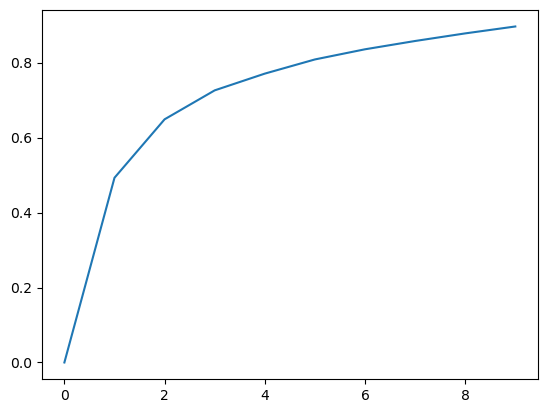

In [27]:
sns.lineplot(pca_elbow)

In [28]:
pca = PCA(n_components=2)

team_pca = pca.fit_transform(team_stats_scaled)
team_pca = pd.DataFrame(team_pca, index=team_stats_scaled.index)

<Axes: xlabel='0', ylabel='1'>

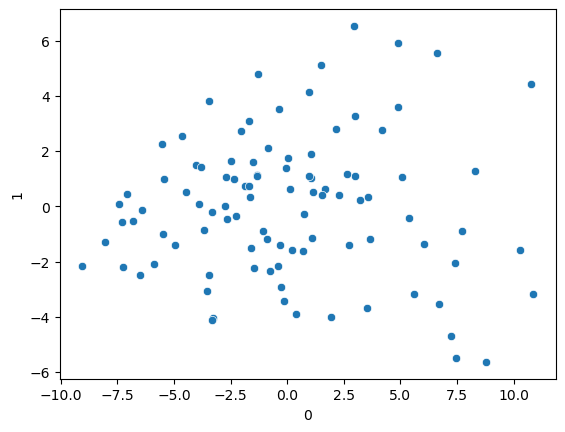

In [29]:
sns.scatterplot(data=team_pca, x=0, y=1)

In [30]:
pca.explained_variance_ratio_.sum()

0.6488219825288866

In [32]:
team_pca.to_csv(f'data/{season}_team_pca.csv')

## Combine with FM and FC data

In [8]:
# load FM data
FM_data = pd.read_csv('./data/FM 2023.csv')
FM_data['dob'] = pd.to_datetime(FM_data['Date of birth'])
FM_data['yob'] = FM_data['dob'].dt.year
# load FC data
FC_data = pd.read_csv('./data/FC24.csv')
FC_data = FC_data[FC_data['update_as_of']=='2022-09-26']
FC_data['dob'] = pd.to_datetime(FC_data['dob'])
FC_data['yob'] = FC_data['dob'].dt.year

In [9]:
fbref_combined_outfielders_grouped = fbref_combined_outfielders_df.groupby('yob')

In [10]:
FM_data['name_match'] = FM_data.progress_apply(lambda row: get_best_match(
    row['Name'], row['yob'], grouped_df=fbref_combined_outfielders_grouped,
    player_col='_Player_', threshold=80), axis=1)

100%|██████████| 8452/8452 [02:04<00:00, 68.16it/s] 


In [11]:
FC_data['name_match'] = FC_data.progress_apply(lambda row: get_best_match(
    row['long_name'], row['yob'], grouped_df=fbref_combined_outfielders_grouped,
    player_col='_Player_', threshold=80), axis=1)

100%|██████████| 18533/18533 [06:41<00:00, 46.20it/s] 


In [12]:
# combine FM and FC dataframes with FBRef
FM_fbref_combined_df = fbref_combined_outfielders_df.merge(right=FM_data, left_on=['_Player_', '_Born_'], right_on=['name_match', 'yob'], how='inner')
FC_fbref_combined_df = fbref_combined_outfielders_df.merge(right=FC_data, left_on=['_Player_', '_Born_'], right_on=['name_match', 'yob'], how='inner')

In [13]:
FM_fbref_combined_df = FM_fbref_combined_df[['_Player_'] + all_stats_columns + FM_columns]
FC_fbref_combined_df = FC_fbref_combined_df[['_Player_'] + all_stats_columns + FC_columns]

In [14]:
# store the combined files
FM_fbref_combined_df.to_csv(f'data/FM_fbref_combined_data_{season}.csv')
FC_fbref_combined_df.to_csv(f'data/FC_fbref_combined_data_{season}.csv')